## Vesuvius Challenge - Ink Detection Training Notebook

### Setup

In [1]:
# # Pretrained weights
# # ref - https://github.com/kenshohara/3D-ResNets-PyTorch
# !pip install gdown
# !gdown 1Nb4abvIkkp_ydPFA9sNPT1WakoVKA8Fa

# # Utility packages for reading and visualizing volumes
# !pip install zarr imageio-ffmpeg

# save model checkpoints
!mkdir ./ckpts

mkdir: cannot create directory ‘./ckpts’: File exists


In [2]:
import os
import gc
import sys
import zarr
import random
import imageio
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import Video

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda import amp
from torch.utils.data import Dataset, DataLoader

sys.path.append("./resnet3d")
from resnet3d import generate_model



import numpy as np
import matplotlib.pyplot as plt

from emnist import extract_training_samples
from emnist import list_datasets
from emnist import extract_test_samples

In [3]:
list_datasets()

['balanced', 'byclass', 'bymerge', 'digits', 'letters', 'mnist']

In [4]:
# get letters
train_images, y_train = extract_training_samples('letters')
valid_images, y_test = extract_test_samples('letters')

In [5]:
train_images.shape, valid_images.shape

((124800, 28, 28), (20800, 28, 28))

In [6]:
# shuffle train_images
idx = np.random.permutation(len(train_images))
train_images = train_images[idx]
# shuffle valid_images
idx = np.random.permutation(len(valid_images))
valid_images = valid_images[idx]

In [7]:
n_images = train_images.shape[0]
train_images = np.reshape(train_images, (n_images//64, 8, 8, 28, 28))
n_images = valid_images.shape[0]
valid_images = np.reshape(valid_images, (n_images//64, 8, 8, 28, 28))
train_images.shape

(1950, 8, 8, 28, 28)

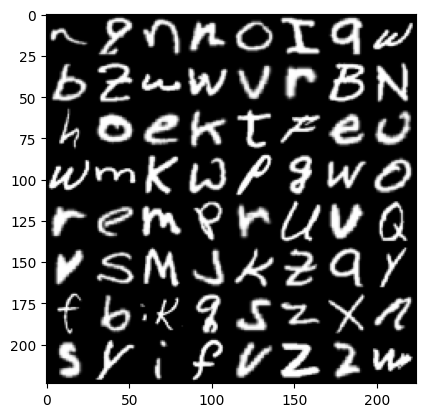

In [8]:
x = np.zeros((8*28, 8*28))
for i in range(8):
    for j in range(8):
        x[i*28:(i+1)*28, j*28:(j+1)*28] = train_images[0, i, j, :, :]


plt.imshow(x, cmap='gray')

### Config

In [9]:
LR = 1e-4
EPOCHS = 50
BATCH_SIZE = 64
CROP_SIZE = 256
Z_DIMS = 16

In [10]:
train_steps = 16
valid_steps = 16

### Dataloaders

In [11]:
import numpy as np
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from torch.utils.data import Dataset
import torch.nn.functional as F
import torch


class EMNISTDataset(Dataset):
    def __init__(self, images, mode='train', CROP_SIZE=256):
        assert mode in ['train', 'valid'], 'mode must be either "train" or "valid"'
        self.mode = mode
        self.images = images
        self.CROP_SIZE = CROP_SIZE
        self.train_aug_list = [
            A.CoarseDropout(max_height=8, max_width=8, max_holes=128, always_apply=True),
            # A.Rotate(90, p=1.0),
            ToTensorV2(transpose_mask=True)
        ]
        self.augmentations_train = A.Compose(self.train_aug_list)
        
        self.valid_aug_list = [
            A.CoarseDropout(max_height=8, max_width=8, max_holes=64, always_apply=True),
            ToTensorV2(transpose_mask=True)
        ]
        self.augmentations_valid = A.Compose(self.valid_aug_list)
        
        
        
        

    def __getitem__(self, i):
        image = self.images[i].astype(np.float32) / 255.0

        x = np.zeros((8*28, 8*28), dtype=np.float32)
        for i in range(8):
            for j in range(8):
                x[i*28:(i+1)*28, j*28:(j+1)*28] = image[i, j, :, :]

        mask = np.copy(x)
        print(x.shape, mask.shape) # prints out (224, 224) (224, 224)
        
        image = np.expand_dims(x, axis=-1)
        mask = np.expand_dims(mask, axis=-1)

        

        # flipped=False
        # if np.random.rand() < 0.5:
        #     flipped=True
        #     image = 1 - image
        
        if self.mode == 'train':
            augmented = self.augmentations_train(image=image)
            image = augmented["image"]
        else:
            augmented = self.augmentations_valid(image=image)
            image = augmented["image"]
        
        # convert mask to tensor
        mask = torch.from_numpy(mask)
            

        # permute from (224, 224, 1) to (1, 224, 224)
        mask = mask.permute(2, 0, 1)
        
        # resize from (1, 224, 224) to (1, 256, 256)
        image = F.interpolate(image.unsqueeze(0), size=self.CROP_SIZE, mode="bilinear", align_corners=False).squeeze(0)
        mask = F.interpolate(mask.unsqueeze(0), size=self.CROP_SIZE, mode="bilinear", align_corners=False).squeeze(0)

        image = (image > 0.5).float()
        mask = (mask > 0.5).float()
        
        image = image.unsqueeze(0)
        
        
        return image, mask

    def __len__(self):
        return len(self.images)


In [15]:
dataset_train = EMNISTDataset(train_images, mode='train')
dataloader_valid = DataLoader(dataset_train, batch_size=BATCH_SIZE, num_workers=1,
                              shuffle=True, pin_memory=True, drop_last=True)

dataset_valid = EMNISTDataset(valid_images, mode='valid')
dataloader_valid = DataLoader(dataset_valid, batch_size=BATCH_SIZE, num_workers=1,
                              shuffle=True, pin_memory=True, drop_last=True)
n_valid = len(dataset_valid)

In [16]:
dataset_valid.images.shape

(325, 8, 8, 28, 28)

In [17]:
len(dataset_train), len(dataloader_train)

NameError: name 'dataloader_train' is not defined

In [18]:
i = random.randint(0, len(dataset_train)-1)
img, label = dataset_train[i]
img.min(), img.max(), img.shape, label.min(), label.max(), label.shape

(224, 224) (224, 224)


(tensor(0.),
 tensor(1.),
 torch.Size([1, 1, 256, 256]),
 tensor(0.),
 tensor(1.),
 torch.Size([1, 256, 256]))

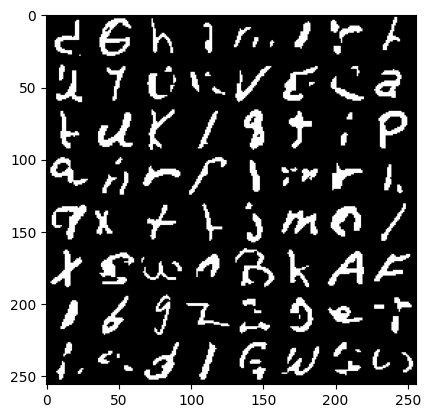

In [19]:
plt.imshow(img[0].squeeze(0), cmap='gray')

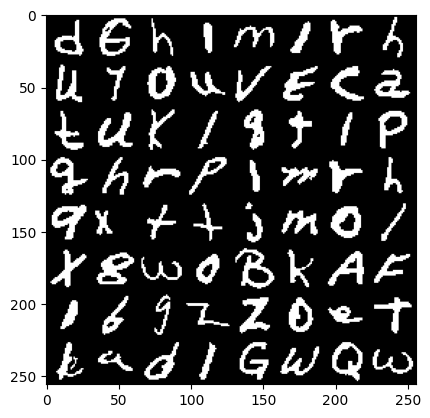

In [20]:
plt.imshow(label.squeeze(0), cmap='gray')

In [21]:
dataset_valid.images.shape

(325, 8, 8, 28, 28)

In [22]:
i = random.randint(0, len(dataset_valid))
img, label = dataset_valid[i]
img.min(), img.max(), img.shape, label.min(), label.max(), label.shape

(224, 224) (224, 224)


(tensor(0.),
 tensor(1.),
 torch.Size([1, 1, 256, 256]),
 tensor(0.),
 tensor(1.),
 torch.Size([1, 256, 256]))

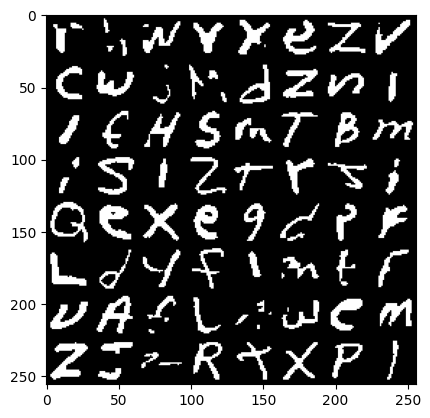

In [23]:
plt.imshow(img[0].squeeze(0), cmap='gray')

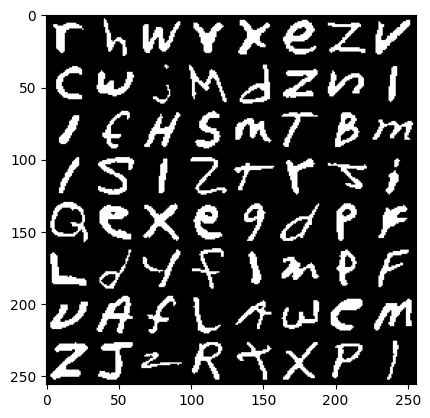

In [24]:
plt.imshow(label.squeeze(0), cmap='gray')

### Model
* Encoder is a 3D ResNet model. The architecture has been modified to remove temporal downsampling between blocks.
* A 2D decoder is used for predicting the segmentation map.
* The encoder feature maps are average pooled over the Z dimension before passing it to the decoder.

In [ ]:
class Decoder(nn.Module):
    def __init__(self, encoder_dims, upscale):
        super().__init__()
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(encoder_dims[i]+encoder_dims[i-1], encoder_dims[i-1], 3, 1, 1, bias=False),
                nn.BatchNorm2d(encoder_dims[i-1]),
                nn.ReLU(inplace=True)
            ) for i in range(1, len(encoder_dims))])

        self.logit = nn.Conv2d(encoder_dims[0], 1, 1, 1, 0)
        self.up = nn.Upsample(scale_factor=upscale, mode="bilinear")

    def forward(self, feature_maps):
        for i in range(len(feature_maps)-1, 0, -1):
            f_up = F.interpolate(feature_maps[i], scale_factor=2, mode="bilinear")
            f = torch.cat([feature_maps[i-1], f_up], dim=1)
            f_down = self.convs[i-1](f)
            feature_maps[i-1] = f_down

        x = self.logit(feature_maps[0])
        mask = self.up(x)
        return mask


class SegModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = generate_model(model_depth=10, n_input_channels=1)
        self.decoder = Decoder(encoder_dims=[64, 128, 256, 512], upscale=4)
        
    def forward(self, x):
        feat_maps = self.encoder(x)
        feat_maps_pooled = [torch.mean(f, dim=2) for f in feat_maps]
        pred_mask = self.decoder(feat_maps_pooled)
        return pred_mask
    
    def load_pretrained_weights(self, state_dict):
        # Convert 3 channel weights to single channel
        # ref - https://timm.fast.ai/models#Case-1:-When-the-number-of-input-channels-is-1
        conv1_weight = state_dict['conv1.weight']
        state_dict['conv1.weight'] = conv1_weight.sum(dim=1, keepdim=True)
        print(self.encoder.load_state_dict(state_dict, strict=False))

In [ ]:
model = SegModel()
model.load_pretrained_weights(torch.load("/home/viktor/Documents/kaggle/vesuvius-challenge/experiments/3D-resnet/r3d18_K_200ep.pth")["state_dict"])
# model = nn.DataParallel(model, device_ids=[0])

_IncompatibleKeys(missing_keys=[], unexpected_keys=['fc.weight', 'fc.bias', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.bn1.running_mean', 'layer1.1.bn1.running_var', 'layer1.1.bn1.num_batches_tracked', 'layer1.1.conv2.weight', 'layer1.1.bn2.weight', 'layer1.1.bn2.bias', 'layer1.1.bn2.running_mean', 'layer1.1.bn2.running_var', 'layer1.1.bn2.num_batches_tracked', 'layer2.1.conv1.weight', 'layer2.1.bn1.weight', 'layer2.1.bn1.bias', 'layer2.1.bn1.running_mean', 'layer2.1.bn1.running_var', 'layer2.1.bn1.num_batches_tracked', 'layer2.1.conv2.weight', 'layer2.1.bn2.weight', 'layer2.1.bn2.bias', 'layer2.1.bn2.running_mean', 'layer2.1.bn2.running_var', 'layer2.1.bn2.num_batches_tracked', 'layer3.1.conv1.weight', 'layer3.1.bn1.weight', 'layer3.1.bn1.bias', 'layer3.1.bn1.running_mean', 'layer3.1.bn1.running_var', 'layer3.1.bn1.num_batches_tracked', 'layer3.1.conv2.weight', 'layer3.1.bn2.weight', 'layer3.1.bn2.bias', 'layer3.1.bn2.running_mean', 'layer3.1.bn2.ru

In [ ]:
x = torch.randn(5, 1, 16, 256, 256)#.cuda()
with torch.no_grad():
    y = model(x)
y.shape

torch.Size([5, 1, 256, 256])

### Training

In [ ]:
scaler = amp.GradScaler()
# criterion = nn.BCEWithLogitsLoss()


optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

In [ ]:
import segmentation_models_pytorch as smp
DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()


def criterion(y_pred, y_true):
    return BCELoss(y_pred, y_true)

In [ ]:
import logging

logging.basicConfig(filename="training_log.txt", level=logging.INFO)


In [ ]:

# Open the log file
with open('training.log', 'w') as log_file:
    
    for epoch in range(1, EPOCHS+1):
        model.train()
        train_losses = []  # list for storing training losses

        for i in tqdm(range(train_steps)):
            batch = next(iter(dataloader_train))
            images, masks = batch
            images, masks = images.cuda().half(), masks.cuda().half()

            optimizer.zero_grad()
            with amp.autocast():
                pred_masks = model(images)
                pred_masks = torch.sigmoid(pred_masks)
                loss = criterion(pred_masks, masks)
                train_losses.append(loss.item())  # store the loss for this batch
                loss.backward()
                optimizer.step()

        avg_train_loss = sum(train_losses) / len(train_losses)  # calculate average training loss
        print(f"\nEpoch: {epoch}, Train Loss: {avg_train_loss}")
        log_file.write(f"Epoch: {epoch}, Train Loss: {avg_train_loss}\n")

        model.eval()
        valid_losses = []  # list for storing validation losses

        for i in tqdm(range(valid_steps)):
            batch = next(iter(dataloader_valid))
            images, masks = batch
            images, masks = images.cuda(), masks.cuda()

            with torch.no_grad():
                pred_masks = model(images)
                pred_masks = torch.sigmoid(pred_masks)
                loss = criterion(pred_masks, masks)
                valid_losses.append(loss.item())  # store the loss for this batch

        avg_valid_loss = sum(valid_losses) / len(valid_losses)  # calculate average validation loss
        print(f"\nEpoch: {epoch}, Valid Loss: {avg_valid_loss}")
        log_file.write(f"Epoch: {epoch}, Valid Loss: {avg_valid_loss}\n")

        # Save the model after each epoch
        torch.save(model.state_dict(), f'./saved_models/model_epoch_{epoch}.pth')
        
        print("\n\n")


100%|██████████| 16/16 [00:06<00:00,  2.44it/s]



Epoch: 1, Train Loss: 0.9012869969010353


100%|██████████| 16/16 [00:06<00:00,  2.44it/s]



Epoch: 1, Valid Loss: 0.8131270483136177





100%|██████████| 16/16 [00:06<00:00,  2.48it/s]



Epoch: 2, Train Loss: 0.9069486446678638


100%|██████████| 16/16 [00:06<00:00,  2.45it/s]



Epoch: 2, Valid Loss: 0.8108150810003281





100%|██████████| 16/16 [00:06<00:00,  2.61it/s]



Epoch: 3, Train Loss: 0.9079431109130383


100%|██████████| 16/16 [00:06<00:00,  2.61it/s]



Epoch: 3, Valid Loss: 0.8566101938486099





100%|██████████| 16/16 [00:06<00:00,  2.57it/s]



Epoch: 4, Train Loss: 0.9067887477576733


100%|██████████| 16/16 [00:06<00:00,  2.43it/s]



Epoch: 4, Valid Loss: 0.8589241541922092





100%|██████████| 16/16 [00:06<00:00,  2.46it/s]



Epoch: 5, Train Loss: 0.9062242992222309


100%|██████████| 16/16 [00:06<00:00,  2.44it/s]



Epoch: 5, Valid Loss: 0.8373269997537136





100%|██████████| 16/16 [00:06<00:00,  2.56it/s]



Epoch: 6, Train Loss: 0.905153926461935


100%|██████████| 16/16 [00:06<00:00,  2.44it/s]



Epoch: 6, Valid Loss: 0.8226491026580334





100%|██████████| 16/16 [00:06<00:00,  2.45it/s]



Epoch: 7, Train Loss: 0.9053537137806416


100%|██████████| 16/16 [00:06<00:00,  2.34it/s]



Epoch: 7, Valid Loss: 0.7784947641193867





100%|██████████| 16/16 [00:06<00:00,  2.50it/s]



Epoch: 8, Train Loss: 0.9044730514287949


100%|██████████| 16/16 [00:06<00:00,  2.48it/s]



Epoch: 8, Valid Loss: 0.7884291000664234





 75%|███████▌  | 12/16 [00:04<00:01,  2.42it/s]


KeyboardInterrupt: 